- https://examples.dask.org/machine-learning/xgboost.html#Learn-more
- http://matthewrocklin.com/blog/work/2017/03/28/dask-xgboost

# setup

In [4]:
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
import dask
import xgboost
import dask_xgboost
from dask.distributed import Client
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc


HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
# p_out=f'{HOME}/output/{PRFX}'
# Path(p_out).mkdir(exist_ok=True)

cols=[
'text_tokens',
'hashtags',
'tweet_id',
'present_media',
'present_links',
'present_domains',
'tweet_type',
'language',
'timestamp',

'engaged_user_id',
'engaged_follower_count',
'engaged_following_count',
'engaged_is_verified',
'engaged_account_creation_time',

'engaging_user_id',
'engaging_follower_count',
'engaging_following_count',
'engaging_is_verified',
'engaging_account_creation_time',

'engagee_follows_engager',
'reply_engagement_timestamp',
'retweet_engagement_timestamp',
'retweet_with_comment_engagement_timestamp',
'like_engagement_timestamp',
]

tgts = ['rply', 'rtwt', 'cmnt', 'like']
cols_tgt_tmstmp = ['reply_engagement_timestamp',
'retweet_engagement_timestamp',
'retweet_with_comment_engagement_timestamp',
'like_engagement_timestamp',
]

ntgts=len(tgts)
subnms = ['Retweet', 'Reply', 'Like', 'RT with comment']
subnm2col = {'Retweet':'rtwt', 'Reply': 'rply', 'Like':'like', 'RT with comment':'cmnt'}

In [5]:
from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# prepare data

In [6]:
# !head -1000000 {p_in}/trn.tsv > {p_in}/trn1e6.tsv
df=dd.read_csv(f'{p_in}/trn1e5.tsv',
               sep='\x01',
               header=None,
               names=cols,)

df[]

In [3]:
i=0
y=~df[cols_tgt[i]].isna().to_dask_array(lengths=True)



df['has_media']=~df.present_media.isna()

X=df[['engaged_follower_count',
      'engaging_following_count',
      'engaged_is_verified', 
      'engagee_follows_engager',
      'engaged_account_creation_time',
      'has_media',]].to_dask_array(lengths=True)
Xtrn, Xval, ytrn, yval = train_test_split(X, y, test_size=0.15)

# train

In [181]:
client = Client(n_workers=4, threads_per_worker=1)

/home/ubuntu/anaconda3/envs/dask-tutorial/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [182]:
params = {'objective': 'binary:logistic'}

bst = dask_xgboost.train(client, params, Xtrn, ytrn, num_boost_round=20)

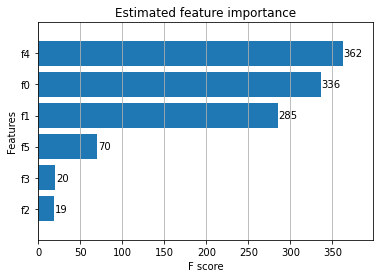

In [183]:
ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [184]:
prdval = dask_xgboost.predict(client, bst, Xval).persist()

In [185]:
yval, prdval = dask.compute(yval, prdval)

In [186]:
def show_roc(prd,y):
    fpr, tpr, _ = roc_curve(y,prd)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, lw=3,
            label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        title="ROC Curve",
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
    )
    ax.legend();
    plt.show()

Reply
prauc: 0.04723442192015412
rce: 2.847181959851275


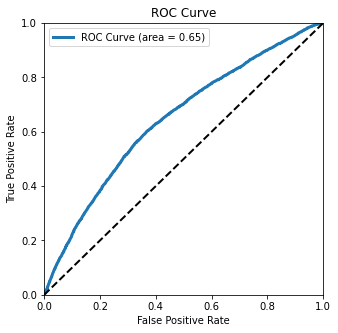

In [189]:
print(cols_subnm[i])
print('prauc:',compute_prauc(prdval, yval))
print('rce:',compute_rce(prdval, yval))
show_roc(prdval, yval)

In [159]:
for i,col in enumerate(cols_subnm):
    print(col)
    print('prauc:',compute_prauc(prdval[:,i], yval[:,i]))
    print('rce:',compute_rce(prdval[:,i], yval[:,i]))
    show_roc(prdval[:,i], yval[:,i])

Reply


IndexError: too many indices for array

# old

https://examples.dask.org/machine-learning/xgboost.html

In [1]:
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:34393 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 64.38 GB


In [2]:
from dask_ml.datasets import make_classification

X, y = make_classification(n_samples=100000, n_features=20,
                           chunks=1000, n_informative=4,
                           random_state=0)
from dask_ml.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
import dask
import xgboost
import dask_xgboost

/home/ubuntu/anaconda3/envs/dask-tutorial/lib/python3.7/site-packages/dask/array/random.py:27: FutureWarning: dask.array.random.doc_wraps is deprecated and will be removed in a future version
  FutureWarning,


In [3]:
params = {'objective': 'binary:logistic',
          'max_depth': 4, 'eta': 0.01, 'subsample': 0.5,
          'min_child_weight': 0.5}

bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=10)

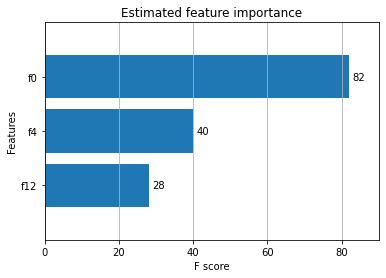

In [4]:
import matplotlib.pyplot as plt

ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [5]:
y_hat = dask_xgboost.predict(client, bst, X_test).persist()
y_hat


,Array,Chunk
Bytes,60.00 kB,600 B
Shape,"(15000,)","(150,)"
Count,100 Tasks,100 Chunks
Type,float32,numpy.ndarray


In [6]:
from sklearn.metrics import roc_curve

y_test, y_hat = dask.compute(y_test, y_hat)
fpr, tpr, _ = roc_curve(y_test, y_hat)

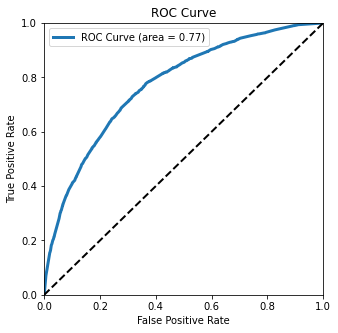

In [7]:
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()